In [1]:
#%reset -f
%matplotlib inline
import math as mt
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from numba import jit

In [2]:
class parametros:
  def __init__(self,a_a,b_b,gamma,d1,d2,size,T,L):
    self.a_a = a_a
    self.b_b = b_b
    self.gamma = gamma
    self.d1 = d1
    self.d2 = d2
    self.size = size
    self.T = T
    self.L = L

  def valores(self):
    dx = self.L / self.size  # paso espacial
    dt = 1*10**(-6)  # paso tiempo
    n = int(self.T / dt)  # numero de iteraciones
    return self.a_a,self.b_b,self.gamma,self.d1,self.d2,self.size,self.T,self.L,dx,dt,n

  def condiciones_iniciales(self):
    U = np.random.rand(self.size, self.size)
    V = np.random.rand(self.size, self.size)
    return U,V

#creación de la clase para reducir código
class grafico_matriz:
  def __init__(self,matriz,L,P):                #definimos lo que recibe
    self.matriz = matriz
    self.P = P
    self.L = L
  def generar_grafico(self):
    vmin = np.min(self.matriz)
    vmax = np.max(self.matriz)
    fig, ax = plt.subplots()
    ax.imshow(self.matriz[1:self.P+2,1:self.P+2], cmap = plt.cm.copper,#cmap='jet',
                interpolation='spline36',
              extent=[0, self.L, 0, self.L],vmin=vmin, vmax=vmax)
    ax.set_axis_off()

#Diferencias finitas:

#Función Laplaciano
@jit(nopython=True)
def laplacian(Z, dx):
    Z_lap = np.zeros_like(Z)
    for i in range(1, Z.shape[0] - 1):
        for j in range(1, Z.shape[1] - 1):
            Z_lap[i, j] = (Z[i-1, j] + Z[i+1, j] + Z[i, j-1] + Z[i, j+1] - 4 * Z[i, j]) / dx**2
    return Z_lap

@jit(nopython=True)
def main_iteration_flujo_nulo(n, gamma, a_a, b_b, d1, d2, dt, U, V):
    for i in range(n):
        # laplaciano de U y V
        deltaU = laplacian(U, dx)
        deltaV = laplacian(V, dx)
        # Valores interiores de U y V
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # Actualizamos las variables
        U[1:-1, 1:-1] = Uc + dt * (d1 * deltaU[1:-1, 1:-1] + gamma * (a_a - Uc + Uc**2 * Vc))
        V[1:-1, 1:-1] = Vc + dt * (d2 * deltaV[1:-1, 1:-1] + gamma * (b_b - Uc**2 * Vc))

        # Condiciones de frontera de Neumann (derivadas nulas)
        for Z in (U, V):
            Z[0, :] = Z[1, :]  # Borde superior
            Z[-1, :] = Z[-2, :]  # Borde inferior
            Z[:, 0] = Z[:, 1]  # Borde izquierdo
            Z[:, -1] = Z[:, -2]  # Borde derecho
        if i == n - 1:
            return U

@jit(nopython=True)
def main_iteration_periodicas(n, gamma, a_a, b_b, d1, d2, dt, U, V):
    for i in range(n):
        # laplaciano de U y V
        deltaU = laplacian(U, dx)
        deltaV = laplacian(V, dx)
        # Valores interiores de U y V
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        # Actualizamos las variables
        U[1:-1, 1:-1] = Uc + dt * (d1 * deltaU[1:-1, 1:-1] + gamma * (a_a - Uc + Uc**2 * Vc))
        V[1:-1, 1:-1] = Vc + dt * (d2 * deltaV[1:-1, 1:-1] + gamma * (b_b - Uc**2 * Vc))

        # Condiciones de frontera periodicas
        for Z in (U, V):
            # Borde izquierdo y derecho
            Z[:, 0] = Z[:, -3] #primer columna le metes los de la penúltima
            
            Z[:, -1] = Z[:, 2] #última columna le metes los de la tercer columna
            
            # Borde superior e inferior
            Z[0, :] = Z[-3, :] #primer renglon le metes los del penúltimo renglón
            
            Z[-1, :] = Z[2, :] #los del último renglón le metes los del tercer renglón

            Z[1, :] = Z[-2, :]

            Z[:, 1] = Z[:, -2]

        if i == n - 1:
            return U


In [7]:
#a_a,b_b,gamma,d1,d2,size,T,L

schnakenberg = parametros(0.14,1.34,10000,1,20,100,0.2,1)

a_a,b_b,gamma,d1,d2,size,T,L,dx,dt,n= schnakenberg.valores()

U,V = schnakenberg.condiciones_iniciales()

result = main_iteration_flujo_nulo(n, gamma, a_a, b_b, d1, d2, dt, U, V)

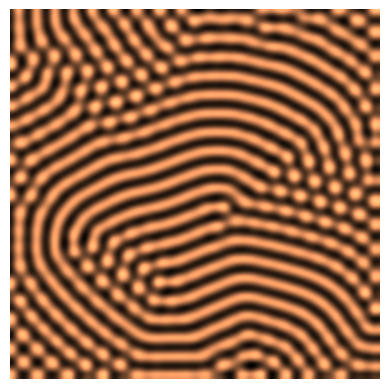

In [6]:
grafico = grafico_matriz(result,L,size)

grafico.generar_grafico()